In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import sempler
from sempler import functions, noise, utils
from sklearn.gaussian_process import GaussianProcessRegressor as GP
import sklearn.gaussian_process.kernels as kernels
import scipy.stats as tests
from termcolor import colored

### Statistical Tests

In [2]:
def t_test(X,Y):
    """Return the p-value of the two sample f-test for
    the given sample"""
    result = tests.ttest_ind(X, Y, equal_var=False)
    return result.pvalue

def f_test(X,Y):
    """Return the p-value of the two sample t-test for
    the given sample"""
    X = X[np.isfinite(X)]
    Y = Y[np.isfinite(Y)]
    F = np.var(X, ddof=1) / np.var(Y, ddof=1)
    p = tests.f.cdf(F, len(X)-1, len(Y)-1)
    return  2*min(p, 1-p)

def ks_test(X,Y):
    return tests.ks_2samp(X,Y)[1]

def wxn_test(X,Y):
    return tests.wilcoxon(X,Y)[1]

def combined(X,Y):
    p_value_mean = t_test(X,Y)
    p_value_var = t_test(X,Y)
    return min(p_value_mean, p_value_var)*2

### Generate data from an ANM

/home/juan/anaconda3/lib/python3.7/site-packages/networkx/drawing/layout.py:923: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))
/home/juan/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/juan/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


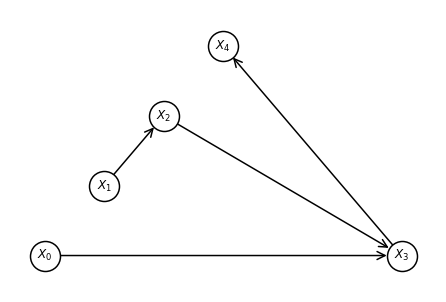

In [3]:
A = np.array([[0, 0, 0, 1, 0],
              [0, 0, 1, 0, 0],
              [0, 0, 0, 1, 0],
              [0, 0, 0, 0, 1],
              [0, 0, 0, 0, 0]
             ])
utils.plot_graph(A)

In [4]:
noise_distributions = [noise.normal(), noise.normal(), noise.normal(0,0.01), noise.normal(0,0.01), noise.normal(0,0.01)]
functions = [None, None, lambda x: np.sin(2*x), lambda x: 1*np.exp(x[:,0]) + 2*x[:,1], lambda x: 2*x]
anm = sempler.ANM(A, functions, noise_distributions)

[-0.25777227 -0.00824698 -0.00689053  1.48182366  2.97116082] [ 1.20492732  0.82370308  0.58152321  7.25146332 28.90461297]


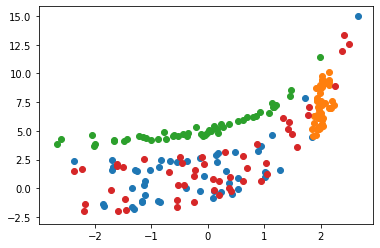

In [5]:
n = 50
X = anm.sample(n, debug=False)
X1 = anm.sample(n, do_interventions = {0: noise.normal(2, 0.01)})
X2 = anm.sample(n, do_interventions = {2: noise.normal(2, 0.01)})
X3 = anm.sample(n, do_interventions = {4: noise.normal(0, 0.01)})
plt.scatter(X[:,0], X[:,3])
plt.scatter(X1[:,0], X1[:,3])
plt.scatter(X2[:,0], X2[:,3])
plt.scatter(X3[:,0], X3[:,3])
print(X.mean(axis=0), X.var(axis=0))

### GP Regression

In [6]:
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [7]:
def regress(data, S, y, plot=False):
    kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
    gpr = GP(n_restarts_optimizer=9, alpha=1).fit(data[:,S], data[:,y])
    base = []
    for i in range(len(S)):
        base.append(np.linspace(data[:,S[i]].min(), data[:,S[i]].max(), 100))
    base = np.vstack(base).T
    if plot:
        (mean, std) = gpr.predict(base, return_std=True)
        top, bottom = mean + std, mean - std        
        plt.plot(base[:,0], mean, color='red')
        plt.fill_between(base[:,0], top, bottom, color='gray', alpha=0.4)
    residuals = data[:,y] - gpr.predict(data[:,S])
    return gpr, residuals

In [8]:
def test_residuals(residuals, idx, test):
    n_env = len(np.unique(idx))
    if n_env == 1:
        return 1
    else:
        p_values = []
        for i,e in enumerate(np.unique(idx)):
            A = residuals[idx == e]
            B = residuals[idx != e]
            p_values.append(test(A,B))
        return min(p_values) * n_env

In [11]:
def ei(i=None,n=50):
    if i is None:
        return anm.sample(n)
    else:
        return anm.sample(n, do_interventions = {i: noise.normal(2, 0.01)})

{0} p=0.000000 l=-3.89 rejected
{1} p=0.000000 l=-6.61 rejected
{2} p=0.000000 l=-6.20 rejected
{4} p=0.000000 l=-3.40 rejected
{0, 1} p=0.000000 l=-3.79 rejected
{0, 2} p=0.000853 l=-2.17 accepted
{0, 4} p=0.000000 l=-3.66 rejected
{1, 2} p=0.000000 l=-6.34 rejected
{1, 4} p=0.000005 l=-4.27 rejected
{2, 4} p=0.000000 l=-3.98 rejected
{0, 1, 2} p=0.000000 l=-2.86 rejected
{0, 1, 4} p=0.000000 l=-4.58 rejected
{0, 2, 4} p=0.000000 l=-4.11 rejected
{1, 2, 4} p=0.000000 l=-4.91 rejected
{0, 1, 2, 4} p=0.000000 l=-5.05 rejected

estimate: {0, 2}


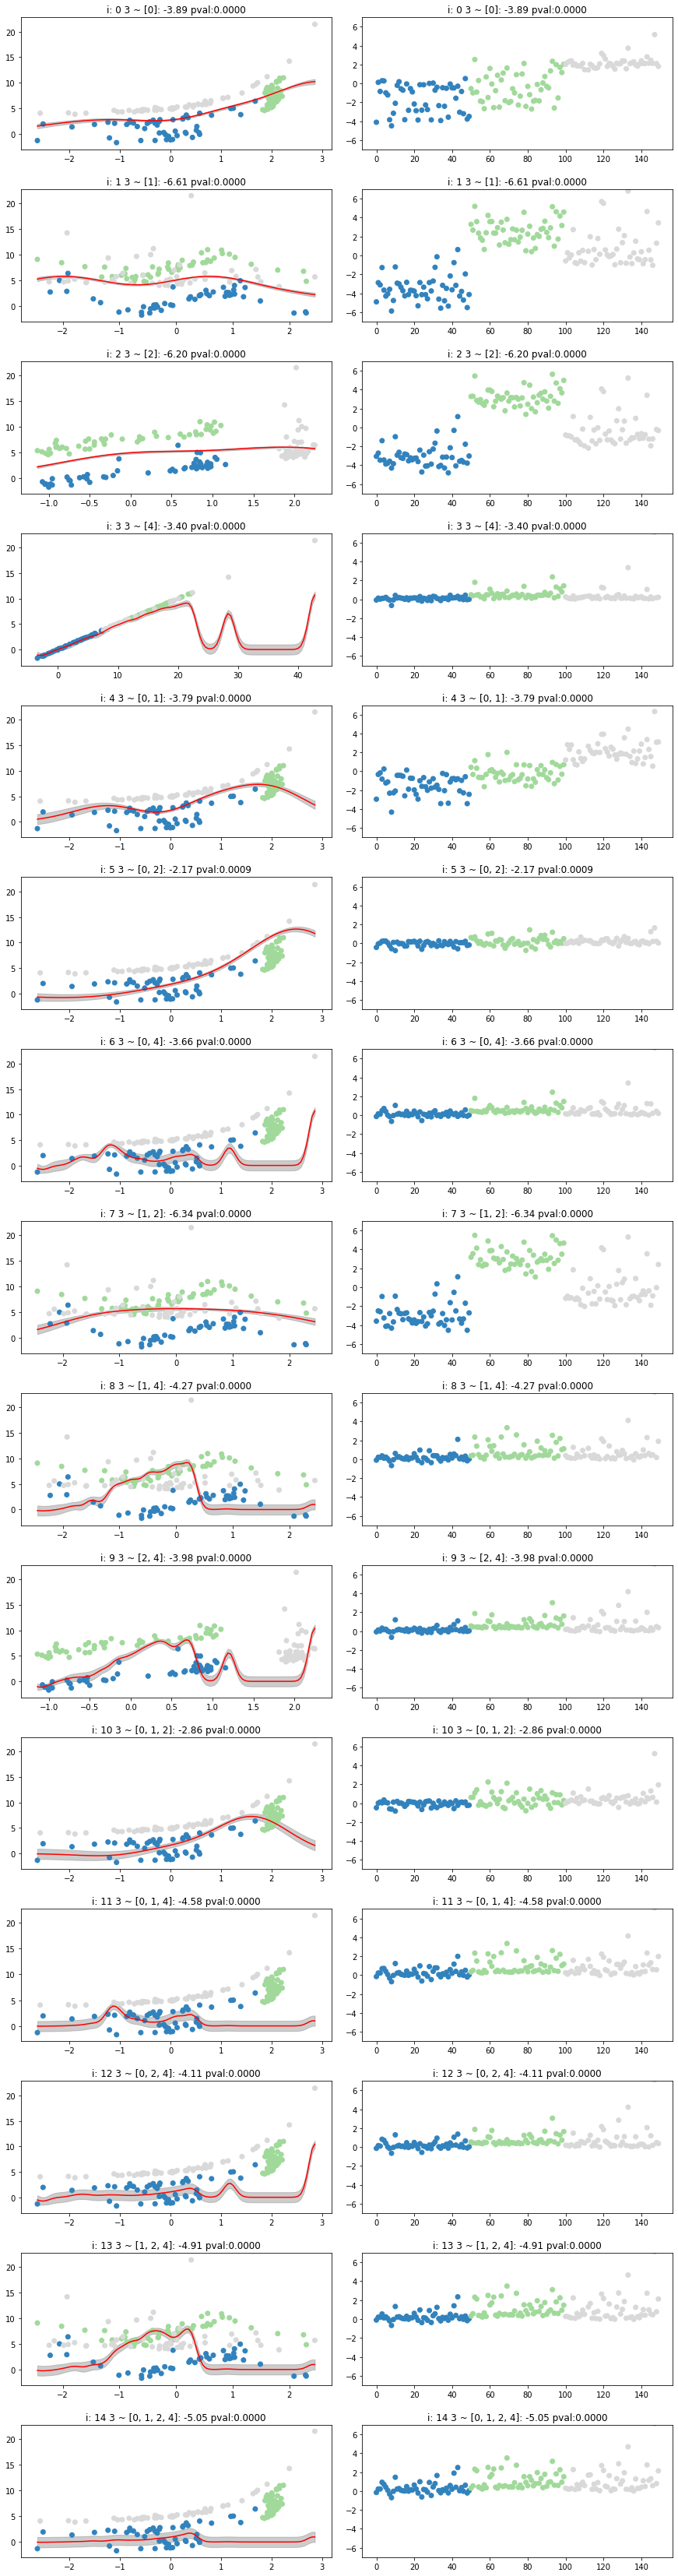

In [12]:
# == Compose experiments == 
response = 2
sets = utils.combinations(anm.p, response, empty=False)

# Generate environments
targets = [None, 0, 2]
names = ["X%d" % i if i is not None else "Obs." for i in targets]
Data = [[ei(i) for i in targets]]

experiments = []
for s in sets:
    for environments in Data:
        experiments.append((response, list(s), environments))

# Run experiments
P_values = []
Likelihoods = []
gs = gridspec.GridSpec(len(experiments), 2, wspace=0.10, hspace=0.3)
plt.figure(figsize=(15,len(experiments)*4))
ylim = [-7,7]
cmap = 'tab20c'
rows = len(experiments) * 2

test = ks_test

for i, (y, S, data) in enumerate(experiments):
    plt.subplot(gs[2*i])
    pooled = np.vstack(data)
    gpr, residuals = regress(pooled, S, y, plot=True)
    likelihood = gpr.log_marginal_likelihood()/len(pooled)
    Likelihoods.append(likelihood)
    idx = []
    for j,Xe in enumerate(data):
        idx = np.hstack([idx, np.ones(len(Xe))*j])
    labels = [names[int(i)] for i in idx]
    p_value = test_residuals(residuals, idx, test)
    P_values.append(p_value)
    plt.scatter(pooled[:, S[0]], pooled[:,y], c=idx, cmap=cmap)
    plt.title("i: %d %d ~ %s: %0.2f pval:%0.4f" % (i, y,S,likelihood, p_value))
    plt.subplot(gs[2*i+1])
    plt.ylim(ylim)
    plt.scatter(np.arange(len(residuals)), residuals, c=idx, cmap=cmap)
    plt.title("i: %d %d ~ %s: %0.2f pval:%0.4f" % (i, y,S,likelihood, p_value))
    
estimate = set(utils.all_but(response, anm.p))
for i,s in enumerate(sets):
    if P_values[i] >= 0.0001:
        status, color = ("accepted", "green")
        estimate = estimate & s
    else:
        status, color = ("rejected", "red")
    msg = "%s p=%0.6f l=%0.2f " % (s, P_values[i], Likelihoods[i]) + status
    print(colored(msg, color))

print("\nestimate: %s" % estimate)